<a href="https://colab.research.google.com/github/lingmHVAC/lingmHVAC/blob/main/Dec17_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


CALIBRATED PARAMETERS
J_in  = 6.47 #/cm3/s
C_g   = 0.0000 µm/s
K     = 2.37e-22 cm3/s
beta  = 1.27e-04 s^-1 µm^-2


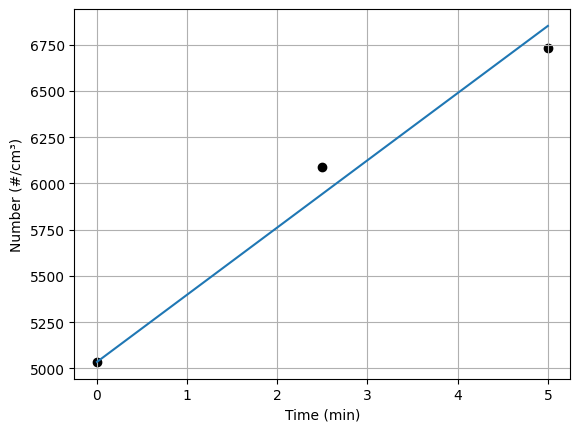

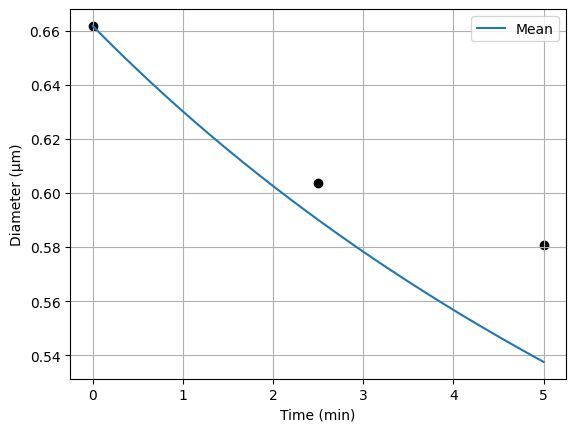

In [2]:
# coagulation and injection, with condensation, and with sedimentation

import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# ============================================================
# MEASURED APS MOMENTS
# ============================================================
t_data = np.array([0, 150, 300])  # s

M_data = np.array([
    [5035, 3332, 3229, 8641],
    [6091, 3678, 3059, 8100],
    [6734, 3912, 3037, 8551]
])

din = 0.35  # µm (APS entry size)

# ============================================================
# 2-NODE QMOM RECONSTRUCTION
# ============================================================
def qmom_nodes(M):
    M0, M1, M2, M3 = M
    mu = M1 / M0
    var = max(M2 / M0 - mu**2, 1e-9)
    std = np.sqrt(var)

    d1 = mu - std
    d2 = mu + std
    w1 = 0.5 * M0
    w2 = 0.5 * M0
    return w1, d1, w2, d2

# ============================================================
# MOMENT RHS
# ============================================================
def moment_rhs(t, y, Jin, Cg, K, beta):
    M0, M1, M2, M3 = y
    M0 = max(M0, 1e-9)

    # QMOM closure for sedimentation
    w1, d1, w2, d2 = qmom_nodes([M0, M1, M2, M3])
    M4 = w1*d1**4 + w2*d2**4
    M5 = w1*d1**5 + w2*d2**5

    dM0 = Jin - 0.5*K*M0**2 - beta*M2
    dM1 = Jin*din + Cg*M0 - beta*M3
    dM2 = Jin*din**2 + 2*Cg*M1 + K*M1**2 - beta*M4
    dM3 = Jin*din**3 + 3*Cg*M2 + 3*K*M1*M2 - beta*M5

    return [dM0, dM1, dM2, dM3]

# ============================================================
# CALIBRATION RESIDUALS
# ============================================================
def residuals(params):
    Jin, Cg, K, beta = params

    sol = solve_ivp(
        lambda t, y: moment_rhs(t, y, Jin, Cg, K, beta),
        [0, 300],
        M_data[0],
        t_eval=t_data,
        rtol=1e-9
    )

    return (sol.y.T - M_data).ravel()

# ============================================================
# PARAMETER FIT
# ============================================================
guess = [10.0, 0.003, 1e-10, 2e-4]
bounds = ([0, 0, 0, 0], [50, 0.02, 1e-8, 1e-2])

res = least_squares(residuals, guess, bounds=bounds)

Jin, Cg, K, beta = res.x

print("\nCALIBRATED PARAMETERS")
print(f"J_in  = {Jin:.2f} #/cm3/s")
print(f"C_g   = {Cg:.4f} µm/s")
print(f"K     = {K:.2e} cm3/s")
print(f"beta  = {beta:.2e} s^-1 µm^-2")

# ============================================================
# FULL TRAJECTORY
# ============================================================
t = np.linspace(0, 300, 400)

sol = solve_ivp(
    lambda t, y: moment_rhs(t, y, Jin, Cg, K, beta),
    [0, 300],
    M_data[0],
    t_eval=t
)

M0, M1, M2, M3 = sol.y
mean_d = M1 / M0

# ============================================================
# MODE (2-NODE)
# ============================================================
mode = np.zeros_like(mean_d)
for i in range(len(t)):
    w1, d1, w2, d2 = qmom_nodes([M0[i], M1[i], M2[i], M3[i]])
    mode[i] = d1 if w1 > w2 else d2

# ============================================================
# PLOTS
# ============================================================
plt.figure()
plt.plot(t/60, M0)
plt.scatter(t_data/60, M_data[:,0], c='k')
plt.ylabel("Number (#/cm³)")
plt.xlabel("Time (min)")
plt.grid()

plt.figure()
plt.plot(t/60, mean_d, label="Mean")
#plt.plot(t/60, mode, '--', label="Mode")
plt.scatter(t_data/60, M_data[:,1]/M_data[:,0], c='k')
plt.ylabel("Diameter (µm)")
plt.xlabel("Time (min)")
plt.legend()
plt.grid()
plt.show()
